In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import json 
from pandas.io.json import json_normalize


df = pd.read_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/COMARR_conso.csv",sep = ';')
df2 = pd.read_csv('/Users/veillonpaul-armand/Documents/Projets/Data/Carto/correspondance-code-insee-code-postal.csv',sep=";")
df2=df2.drop(["Code Canton","Code Arrondissement","ID Geofla","Commune","Département","Région"],axis=1)



In [2]:
#Merge on df
df=df.merge(df2,how="right",left_on="CODGEO", right_on="Code INSEE")

#Pour les codes postales avec plusieur communes, assignés au CP la population moyenne pondérée des villages
df['Counts'] = df.groupby(['Code Postal'])['CODGEO'].transform('count')
df['POP_CP'] = df.groupby(['Code Postal'])['Population'].transform('sum')
df['POP_mean_CP']=df['Population'] **2/df['POP_CP']
df['POP_mean_CP']=df.groupby(['Code Postal'])['POP_mean_CP'].transform('sum')
df.head(5)




,CODGEO,LIBGEO,DEP,NATURE_EPCI,ZE2010,UU2010,TUU2015,TDUU2015,AU2010,TAU2015,...,Statut,Altitude Moyenne,Superficie,Population,Code Commune,Code Département,Code Région,Counts,POP_CP,POP_mean_CP
0,1001,L'Abergement-Clémenciat,1,CC,8213.0,1000,0.0,5.0,997,0.0,...,Commune simple,242.0,1565.0,0.8,1,1,82,10,11.0,2.654545
1,1002,L'Abergement-de-Varey,1,CC,8201.0,1000,0.0,4.0,2,9.0,...,Commune simple,483.0,912.0,0.2,2,1,82,4,4.1,1.631707
2,1004,Ambérieu-en-Bugey,1,CC,8201.0,1302,3.0,32.0,2,9.0,...,Chef-lieu canton,379.0,2448.0,13.4,4,1,82,8,22.6,8.618584
3,1005,Ambérieux-en-Dombes,1,CC,8213.0,1000,0.0,6.0,2,9.0,...,Commune simple,290.0,1605.0,1.6,5,1,82,8,7.8,2.782051
4,1006,Ambléon,1,CC,8216.0,1000,0.0,3.0,998,0.0,...,Commune simple,589.0,602.0,0.1,6,1,82,23,19.1,4.298953


In [3]:
df['CP_TUU']=df.groupby(['Code Postal'])['TUU2015'].transform("max")
print(df.groupby(['CP_TUU'])['CODGEO'].count())

df=df[["Code Région","Code Département","Code Postal","Code INSEE","Counts","POP_CP","POP_mean_CP","CP_TUU","LIBGEO"]]
df=df.drop_duplicates(["Code Région","Code Département","Code Postal"])



CP_TUU
0.0    14535
1.0     7315
2.0     4607
3.0     2500
4.0     2210
5.0     1181
6.0      766
7.0     1759
8.0      523
Name: CODGEO, dtype: int64


In [4]:

df.groupby(['CP_TUU'])['Code INSEE'].count()
vec=df.loc[df["Code Postal"].str.find("/")!=(-1),"Code Postal"]




In [5]:
vec=df.loc[df["Code Postal"].str.find("/")!=(-1),"Code Postal"]
m=df.shape[0] 

for i in vec:
    cp=i.split("/")
    df_bis=df[df["Code Postal"]==i] 
   
    for j in cp:
        df_bis["Code Postal"]=j
        df=pd.concat([df,df_bis])

df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df=df[~df["Code Postal"].isin(vec)]
df.head(5)


    

/Users/veillonpaul-armand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Code Région,Code Département,Code Postal,Code INSEE,Counts,POP_CP,POP_mean_CP,CP_TUU,LIBGEO
0,82,1,1400,1001,10,11.0,2.654545,1.0,L'Abergement-Clémenciat
1,82,1,1640,1002,4,4.1,1.631707,1.0,L'Abergement-de-Varey
2,82,1,1500,1004,8,22.6,8.618584,3.0,Ambérieu-en-Bugey
3,82,1,1330,1005,8,7.8,2.782051,1.0,Ambérieux-en-Dombes
4,82,1,1300,1006,23,19.1,4.298953,3.0,Ambléon


In [6]:
df.to_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/CP_conso.csv")

In [7]:
#Merge with data grand débat
with open("/Users/veillonpaul-armand/Documents/Projets/Data/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN=json_normalize(json_data)
df_GN['Thème']="Fiscalité"

with open("/Users/veillonpaul-armand/Documents/Projets/Data/LA_TRANSITION_ECOLOGIQUE_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN1=json_normalize(json_data)
df_GN1['Thème']="Transition Ecologique"
df_GN=pd.concat([df_GN,df_GN1])

with open("/Users/veillonpaul-armand/Documents/Projets/Data/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN1=json_normalize(json_data)
df_GN1['Thème']="Organisation de l'Etat"
df_GN=pd.concat([df_GN,df_GN1])

with open("/Users/veillonpaul-armand/Documents/Projets/Data/DEMOCRATIE_ET_CITOYENNETE_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN1=json_normalize(json_data)
df_GN1['Thème']="Démocratie et Citoyenneté"
df_GN=pd.concat([df_GN,df_GN1])

del df_GN1
del json_data

In [8]:

#Cleaning CP
df_GN["authorZipCode"]=pd.to_numeric(df_GN["authorZipCode"])
df_GN.loc[df_GN["authorZipCode"]<1000,"authorZipCode"]=np.nan
df_GN.loc[df_GN["authorZipCode"]>98999,"authorZipCode"]=np.nan
df_GN["DEP"]=df_GN["authorZipCode"]/1000
df_GN["DEP"]=df_GN["DEP"].fillna(0).astype('int')
df_GN.groupby(['DEP'])['reference'].count()




DEP
0      2818
1      2843
2      1080
3      1109
4       913
5       816
6      4727
7      1718
8       652
9       658
10      836
11     1560
12     1106
13     8205
14     2241
15      571
16     1032
17     2913
18      950
19      768
20      720
21     2346
22     2139
23      517
24     1687
25     1778
26     2426
27     1814
28     1431
29     3393
      ...  
69     9709
70      666
71     1838
72     1667
73     2010
74     3475
75    14735
76     3516
77     4346
78     8312
79     1079
80     1201
81     1607
82      876
83     4691
84     2217
85     2218
86     1400
87     1433
88     1127
89      980
90      536
91     4674
92     8822
93     2465
94     4656
95     3250
96        4
97     1587
98      230
Name: reference, Length: 99, dtype: int64

In [9]:
#Create table at dep level
pop = pd.read_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/pop_dep.csv",sep = ';')

#All contributions
all_ref=df_GN.groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_all","Total":"Population"},inplace=True)
pop["Count_all"]=pd.to_numeric(pop["Count_all"])
pop["Count_pourmil"]=pop["Count_all"]/pop["Population"]*1000

#Fisca
all_ref=df_GN[df_GN["Thème"]=="Fiscalité"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_fisca"},inplace=True)
pop["Count_fisca"]=pd.to_numeric(pop["Count_fisca"])
pop["perc_fisca"]=pop["Count_fisca"]/pop["Count_all"]

#Ecologie
all_ref=df_GN[df_GN["Thème"]=="Transition Ecologique"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_ecolo"},inplace=True)
pop["Count_ecolo"]=pd.to_numeric(pop["Count_ecolo"])
pop["perc_ecolo"]=pop["Count_ecolo"]/pop["Count_all"]

#Citoyenneté
all_ref=df_GN[df_GN["Thème"]=="Démocratie et Citoyenneté"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_cit"},inplace=True)
pop["Count_cit"]=pd.to_numeric(pop["Count_cit"])
pop["perc_cit"]=pop["Count_cit"]/pop["Count_all"]

#Etat
all_ref=df_GN[df_GN["Thème"]=="Organisation de l'Etat"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_etat"},inplace=True)
pop["Count_etat"]=pd.to_numeric(pop["Count_etat"])
pop["perc_etat"]=pop["Count_etat"]/pop["Count_all"]

pop.to_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/GN_conso_dep_level.csv")

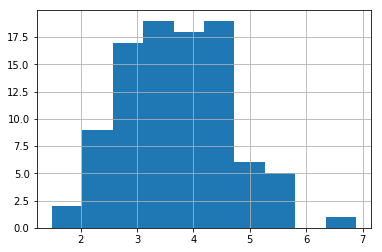

In [10]:
pop["Count_pourmil"].hist()

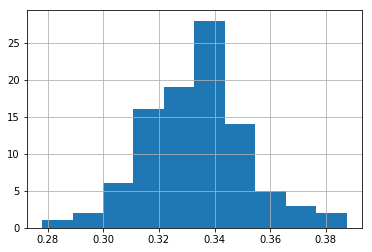

In [11]:
pop["perc_fisca"].hist()

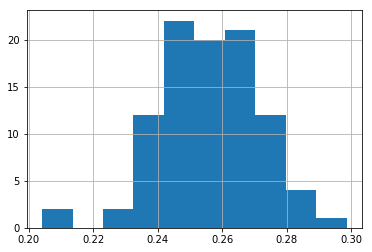

In [12]:
pop["perc_ecolo"].hist()

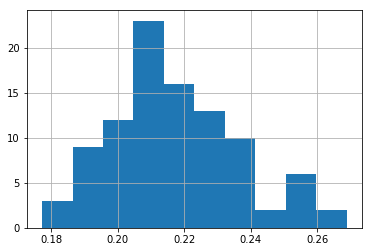

In [13]:
pop["perc_etat"].hist()

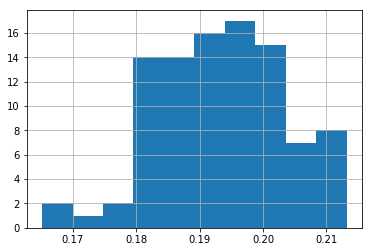

In [14]:
pop["perc_cit"].hist()